# Load libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define functions

In [2]:
# Function that calculates the weighted sum of the squares of the distance between the model and the data
# This is the so called "cost function"
# x, y : Data
# w : Weights
# model : The model function which is a function of x and a
# a : Model parameters

def S(x, y, w, model, a):
    return np.sum(w*(y-model(x, a))**2)


# Function that numerically calculates the first derivative of S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a : Model parameters
# delta : The differential of a, we will calculate S at the positions a - delta and a + delta

def dS(S, x, y, w, model, a, delta):
    # Numerical calculation of the first derivative of S
    
    # Number of fit parameters
    m = len(a)
    
    # Return vector 
    delta_S = np.zeros(m)
    
    # Iterate over all parameters
    for i in range(0,m):
        # Differential vector for only the differentiation parameter (partial differentiation)
        delta_a = np.zeros(m)
        delta_a[i] = delta
        
        # Differential vector at the position a
        delta_a_plus = a + delta_a
        delta_a_minus = a - delta_a
        
        # Calculate partial differential for i-th parameter 
        delta_S[i] = (S(x, y, w, model, delta_a_plus)-S(x, y, w, model, delta_a_minus))/(2*delta)
    return delta_S


# Function that numerically calculates the second derivative of S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a : Model parameters
# delta : The differential of a

def dS2(S, x, y, w, model, a, delta):
    # Numerical calculation of the decond derivatice of S
    
    # Number of fit parameters
    m = len(a)
    
    # Return vector 
    delta_S = np.zeros((m,m))
    
    # Iterate over all parameters
    for i in range(0,m):
        for j in range(0,m):
            # Differential vector for only the differentiation parameter (partial differentiation)
            delta_ai = np.zeros(m)
            delta_aj = np.zeros(m)
            delta_ai[i] = delta
            delta_aj[j] = delta
                       
            # Differential vector at the position a
            delta_a_plusplus = a + delta_ai + delta_aj
            delta_a_plusminus = a + delta_ai - delta_aj
            delta_a_minusplus = a - delta_ai + delta_aj
            delta_a_minusminus = a - delta_ai - delta_aj           
            
            # Calculate partial differential for i-th parameter 
            delta_S[i,j] = (S(x, y, w, model, delta_a_plusplus)-S(x, y, w, model, delta_a_minusplus)-S(x, y, w, model, delta_a_plusminus)+S(x, y, w, model, delta_a_minusminus))/(2*delta)**2
    return delta_S

# Function that returns the length, or norm of a vector, equivalent to the numpy function linalg.norm

def length(a):
    # Length of vector a
    a_length = 0
    for a_i in a:
        a_length = a_length + a_i**2
    return np.sqrt(a_length)


# Function that performs a gradient descent algorithm to minimize the cost function S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a_init : Initial guess for the fir parameters
# min_gradient : Termination condition based on the minimal gradient
# max_i: Termination condition based on the maximal number of iterations
# alpha : Scaling parameter of the gradient
# delta : The differential of a

def gradient_descent_simple(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    # Magnitude of the gradient
    d_a = np.array([length(gradient)])
    

    
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i] > min_gradient) and (i < max_i)):
        
        # Calculate next step using the gradient 
        a_next = a_next - alpha * gradient
        # Calculate next gradient
        gradient =  dS(S, x, y, w, model, a_next, delta)
        
        # Termination condition
        d_a = np.append(d_a, [length(gradient)])
    
        # Next Step
        i = i + 1
    
    return a_next, i, d_a


# Function that performs the improved gradient descent algorithm to minimize the cost function S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a_init : Initial guess for the fir parameters
# min_gradient : Termination condition based on the minimal gradient
# max_i: Termination condition based on the maximal number of iterations
# alpha : Scaling parameter of the gradient
# delta : The differential of a

def gradient_descent(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and Hesse matrix for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    hesse = dS2(S, x, y, w, model, a_next, delta)
    hdiag = np.diagonal(hesse)
    # Magnitude of the gradient
    d_a = np.array([length(gradient)])
    

    
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i] > min_gradient) and (i < max_i)):
        
        # Calculate next step using the gradient 
        a_next = a_next - alpha * 1/hdiag * gradient
        
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        hesse = dS2(S, x, y, w, model, a_next, delta)
        hdiag = np.diagonal(hesse)
        
        # Termination condition
        d_a = np.append(d_a, [length(gradient)])
    
        # Next Step
        i = i + 1
    
    return a_next, i, d_a


# Function that performs the Newton method to minimize the cost function S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a_init : Initial guess for the fir parameters
# min_gradient : Termination condition based on the minimal gradient
# max_i: Termination condition based on the maximal number of iterations
# alpha : Scaling parameter of the gradient
# delta : The differential of a

def Newton(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
   
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and Hesse matrix for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    hesse = dS2(S, x, y, w, model, a_next, delta)
    # Magnitude of the gradient
    d_a = np.array([length(gradient)])
    

    
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i] > min_gradient) and (i < max_i)):
        
    
        # a_next = a_next - alpha * gradient
        a_next = a_next - alpha * np.linalg.inv(hesse)@gradient
        
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        hesse = dS2(S, x, y, w, model, a_next, delta)
        
        # Termination condition
        d_a = np.append(d_a, [length(gradient)])
    
        # Next Step
        i = i + 1
    
    return a_next, i, d_a


# Function that performs the Marquardt method to minimize the cost function S
# S : The function S
# x, y : Data
# w : Weights
# model : The model function
# a_init : Initial guess for the fir parameters
# min_gradient : Termination condition based on the minimal gradient
# max_i: Termination condition based on the maximal number of iterations
# alpha : Scaling parameter of the gradient
# delta : The differential of a

def Marquardt(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):

    m = len(a_init)
    alpha_mod = np.identity(m) * (1 + alpha)
    
    # First step
    # ----------
    
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and Hesse matrix for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    hesse = dS2(S, x, y, w, model, a_next, delta)
    hmod = hesse@alpha_mod
    # Magnitude of the gradient
    d_a = np.array([length(gradient)])
    

    
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i] > min_gradient) and (i < max_i)):
        
        # Calculate next step using the gradient 
        a_next = a_next - np.linalg.inv(hmod)@gradient
        
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        hesse = dS2(S, x, y, w, model, a_next, delta)
        hmod = hesse@alpha_mod
        
        # Termination condition
        d_a = np.append(d_a, [length(gradient)])
    
        # Next Step
        i = i + 1
    
    return a_next, i, d_a



# Create Data

## Model

Polynomial model with <strong>a</strong> being a vector holding the polynomial parameters, <strong>a</strong>[0] is the offset, <strong>a</strong>[1] the linear parameter ... 

In [3]:
def model(x, a):
    y = 0
    i = 0
    for ai in a:
        y = y + ai*x**i
        i = i + 1
    return y

Exponential decay model <strong>a</strong> being a vector holding the parameters, amplitude <strong>a</strong>[0] and decay <strong>a</strong>[1]

In [4]:
def model(x, a):
    return a[0]*np.exp(-a[1]*x)

## Independent variable - x

In [5]:
x_min = 0
x_max = 1
x_n = 10

x = np.linspace(x_min, x_max, x_n)

## Dependent variable - y

## Model parameters

In [6]:
# Vector holding the values of the model parameters
a = np.array([1, 5])

## Simulate experiment

In [7]:
# Number of measurements per data point
m = 10

# Measurement uncertainty
sigma = 0.05

In [8]:
# Full measurement data

# Generate empty arrays
y_meas = np.zeros((x_n,m)) # Array holding all individual measurement values
y = np.zeros(x_n) # Vector holding the y values, the mean value of all measurements taken per x_i
w = np.zeros(x_n) # Vector holding the weights of the data points = 1/variance of each y


i = 0
# go through all x as x_i
for x_i in x:
    # generate m measured values per x value
    # m normally distributed random numbers reflecting the measurement uncertainty
    noise = np.random.normal(0,1,m)
    # generate m measured values 
    y_i = model(x_i, a)+noise*sigma
    y_meas[i,:] = y_i
    # calculate the mean of all measured values    
    y[i] = np.sum(y_i)/m
    # and the weights (as invers variance)
    w[i] = (m-1)/np.sum((y_i-y[i])**2)
    # increment
    i = i+1


## Plot data

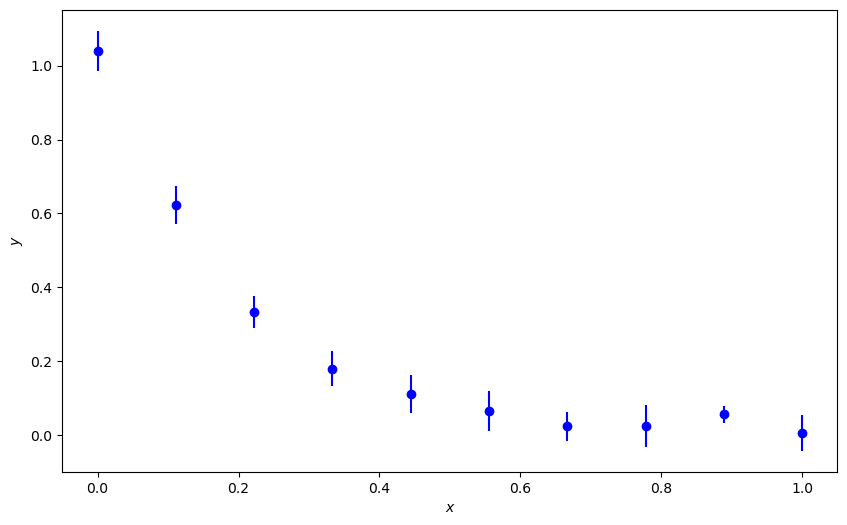

In [9]:
# plot data
plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xscale('linear')
plt.yscale('linear')
plt.errorbar(x,y,yerr=np.sqrt(1/w), fmt='bo')
plt.show()

# Non-linear regression

### Gradient descent

In [10]:
#a_init = np.array([10.0, 1.0])
a_init = np.array([2.0, 1.0])

delta = 0.001 # differential for numerical differntiation
alpha = 0.0001 # scaling factor for gradient descent


a_next_0, i_0, d_a_0 = gradient_descent_simple(S, x, y, w, model, a_init, 1e-1, 10000, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit: ',a_next_0)
i = 0
for ai in a_next_0:
    print("a_{} = {:0.2f}".format(i, ai))
    i = i+1
print('Iterations: ', i_0)
print('Amplitude = {:0.2f}'.format(a_next_0[0]))
print('Gamma = {:0.2f}'.format(a_next_0[1]))

Fit Results:
Best fit:  [1.04322885 4.94864637]
a_0 = 1.04
a_1 = 4.95
Iterations:  4195
Amplitude = 1.04
Gamma = 4.95


### Newton's Method

In [11]:
a_init = np.array([2.0, 1.0])

delta = 0.001 # differential for numerical differntiation
alpha = 0.1 # scaling factor for gradient descent


a_next_2, i_2, d_a_2 = Newton(S, x, y, w, model, a_init, 1e-1, 10000, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit:')
i = 0
for ai in a_next_2:
    print("a_{} = {:0.2f}".format(i, ai))
    i = i+1
print('============')
print('Iterations: ', i_2)
print('Amplitude = {:0.2f}'.format(a_next_2[0]))
print('Gamma = {:0.2f}'.format(a_next_2[1],))

Fit Results:
Best fit:
a_0 = 1.04
a_1 = 130.06
Iterations:  234
Amplitude = 1.04
Gamma = 130.06


### Gradient descent with modified alpha

In [12]:
#a_init = np.array([10.0, 1.0])
a_init = np.array([2.0, 1.0])

delta = 0.001 # differential for numerical differntiation
alpha = 1 # scaling factor for gradient descent


a_next_1, i_1, d_a_1 = gradient_descent(S, x, y, w, model, a_init, 1e-1, 10000, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit:')
i = 0
for ai in a_next_1:
    print("a_{} = {:0.2f}".format(i, ai))
    i = i+1
print('============')
print('Iterations: ', i_1)
print('Amplitude = {:0.2f}'.format(a_next_1[0]))
print('Gamma = {:0.2f}'.format(a_next_1[1]))

Fit Results:
Best fit:
a_0 = 1.04
a_1 = 4.96
Iterations:  18
Amplitude = 1.04
Gamma = 4.96


### Marquardt's Method

In [13]:
a_init = np.array([2.0, 1.0])

delta = 0.001 # differential for numerical differntiation
alpha = 1 # scaling factor for gradient descent


a_next_3, i_3, d_a_3 = Marquardt(S, x, y, w, model, a_init, 1e-1, 10000, alpha, delta)

print('Fit Results:')
print('============')
print('Best fit:')
i = 0
for ai in a_next_3:
    print("a_{} = {:0.2f}".format(i, ai))
    i = i+1
print('============')
print('Iterations: ', i_3)
print('Amplitude = {:0.2f}'.format(a_next_3[0]))
print('Gamma = {:0.2f}'.format(a_next_3[1]))

Fit Results:
Best fit:
a_0 = 1.04
a_1 = 4.96
Iterations:  17
Amplitude = 1.04
Gamma = 4.96


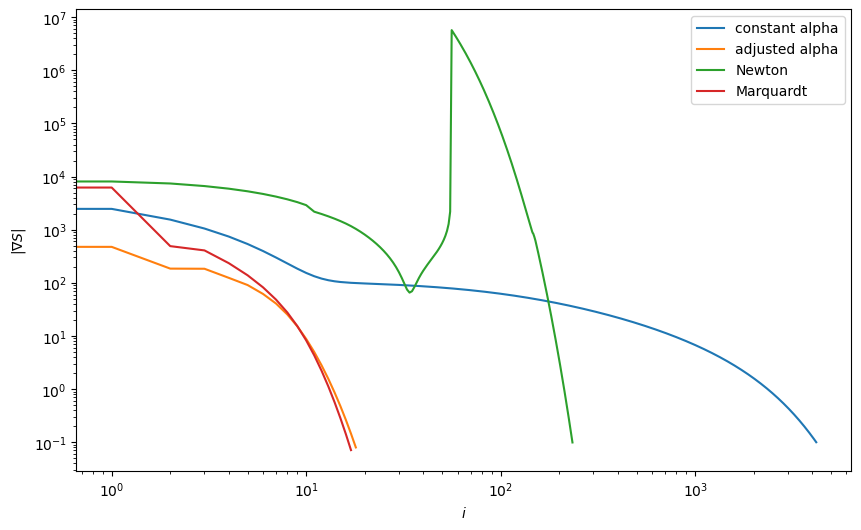

In [14]:
# plot convergence
plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel(r'$i$')
plt.ylabel(r'|$\nabla S|$')
plt.xscale('log')
plt.yscale('log')
plt.plot(np.linspace(0,i_0,i_0+1),d_a_0, label='constant alpha')
plt.plot(np.linspace(0,i_1,i_1+1),d_a_1, label='adjusted alpha')
plt.plot(np.linspace(0,i_2,i_2+1),d_a_2, label='Newton')
plt.plot(np.linspace(0,i_3,i_3+1),d_a_3, label='Marquardt')
plt.legend()
plt.show()

In [15]:
y_fit_0 = model(x, a_next_0)
y_fit_1 = model(x, a_next_1)
y_fit_2 = model(x, a_next_2)
y_fit_3 = model(x, a_next_3)

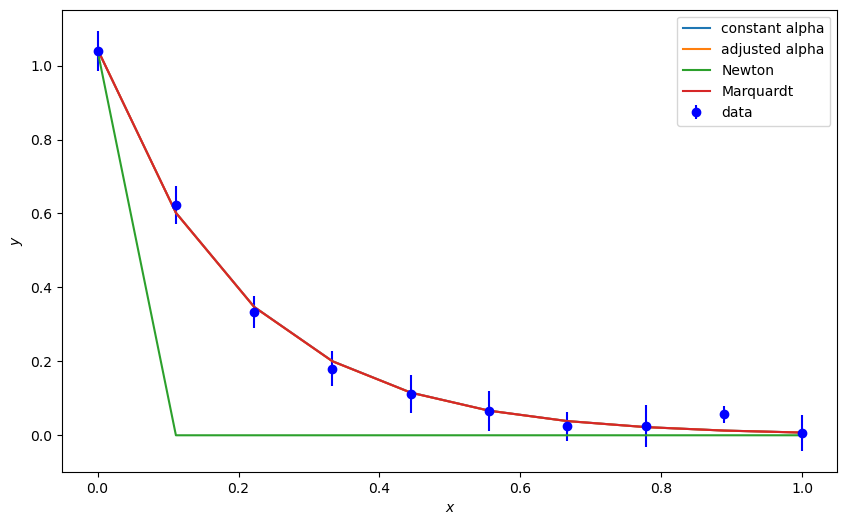

In [16]:
# plot data
plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xscale('linear')
plt.yscale('linear')
plt.errorbar(x,y,yerr=np.sqrt(1/w), fmt='bo', label='data')
plt.plot(x,y_fit_0, label='constant alpha')
plt.plot(x,y_fit_1, label='adjusted alpha')
plt.plot(x,y_fit_2, label='Newton')
plt.plot(x,y_fit_3, label='Marquardt')
plt.legend()
plt.show()